# Partie 1 : Apprentissage supervisé
## `20newsgroups` **avec** stopwords
**Remarque** : les classifieurs KNN multi-classe, Perceptron sans biais, Naïf Bayes ont été optimisés pour les matrices creuses *(sparse array)* de ***scipy***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

import time

import sys
sys.path.append('../') 

from iads import Classifiers as classif
from iads import utils as ut
from iads import evaluation as ev
from iads import Clustering as clust

# Vectorisation des docs avec BoW (binaire ou non), TfIdf
from iads.vectorization import get_bow_vect, get_tfidf_vect

# Prétraitement du text 
from iads.preprocessing import get_corpus, clean_news, lemmatize_filter

sns.set_theme()
plt.rcParams['font.family'] = 'Proxima Nova'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Chargement des données

In [16]:
newsgroups_df = pd.read_csv("data/sample.csv")
stop_words_df = pd.read_csv("data/stopwords.csv")
stopwords = stop_words_df["stopword"].values.tolist()

news_no_stopwords = clean_news(newsgroups_df, stopwords, delete_stopwords=False, delete_digits=True)
news_no_stopwords = lemmatize_filter(news_no_stopwords, 3, 10)
corpus = get_corpus(news_no_stopwords)
news_no_stopwords
news_no_stopwords

Number of Nans 48


,Message index,target,label,messages
0,0,0,alt.atheism,law seem value criminal life more than the vic...
1,1,0,alt.atheism,from com bill newsgroups alt atheism organizat...
2,2,0,alt.atheism,the true believer die for their belief jesus j...
3,3,0,alt.atheism,knowing keith expect he'll bring the better oi...
4,4,0,alt.atheism,film about the medium you alternative movie so...
...,...,...,...,...
1814,1879,19,comp.os.ms-windows.misc,think you are mistaken thinking tom atheist yo...
1815,1881,19,comp.os.ms-windows.misc,because that would your religious belief there...
1816,1882,19,comp.os.ms-windows.misc,extremely good example evidence every time the...
1817,1883,19,comp.os.ms-windows.misc,vol part from the ocean the translation from t...


##### Naïf Bayes

------ affichage validation croisée
Itération 0: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.3848
Itération 1: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.3539
Itération 2: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.3596
Itération 3: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.3427
Itération 4: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.3624
------ fin affichage validation croisée
Results [0.3848314606741573, 0.3539325842696629, 0.3595505617977528, 0.34269662921348315, 0.36235955056179775]
Mean accuracy 0.3607, std : 0.0138
Time 1.2439451217651367


Text(0.5, 1.0, 'Confusion matrix')

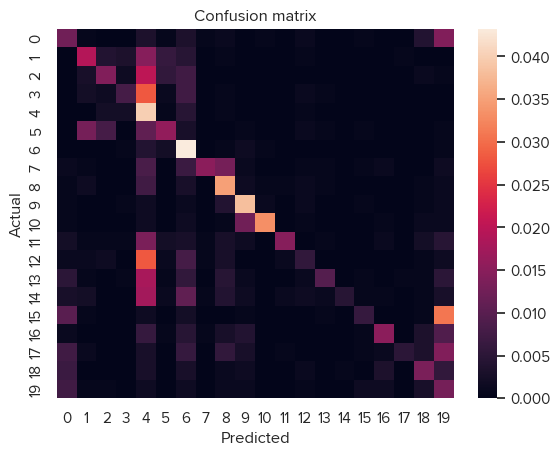

In [17]:
news_labels = news_no_stopwords["target"].values
# !Important! BoW non binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)

bayes = classif.NaiveBayes(news_desc.shape[1], corpus, np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(bayes, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

### Déterminer K pour KNN pour différents méthode de vectorisation

In [18]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

news_desc_bow_bin = get_bow_vect(news_no_stopwords, corpus, True)
news_desc_bow_freq = get_bow_vect(news_no_stopwords, corpus, False)
news_desc_tfidf = get_tfidf_vect(news_no_stopwords, corpus)

1
3
5
7
9
11
13
15
17
19


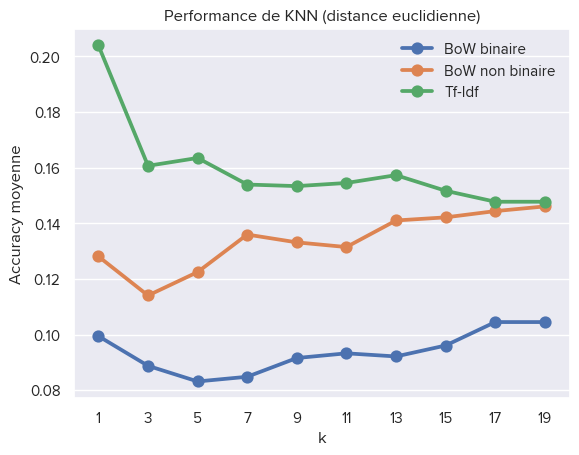

In [19]:
k_values, means = np.arange(1, 21, 2), []

for k in k_values:
    print(k)
    np.random.seed(1)
    classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=k, C=n_classes, dist_type="euclidean")

    (_, mean_bow_bin, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_bin, news_labels), 5, False, False)
    (_, mean_bow_freq, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_freq, news_labels), 5, False, False)
    (_, mean_tfidf, _) = ev.validation_croisee(classifier_knn, (news_desc_tfidf, news_labels), 5, False, False)

    means.append([mean_bow_bin, mean_bow_freq, mean_tfidf])

data=pd.DataFrame(data={"k":k_values, "mean accuracy":means})
data[['BoW binaire', 'BoW non binaire', "Tf-Idf"]] = pd.DataFrame(data["mean accuracy"].to_list(),
                                                                  columns=['BoW binaire', 'BoW non binaire', "Tf-Idf"],
                                                                  index = data.index)
data = data.drop(columns="mean accuracy")
data = data.melt(id_vars="k", value_vars=['BoW binaire', 'BoW non binaire', "Tf-Idf"], var_name="vectorisation", value_name="Accuracy moyenne")

ax = sns.pointplot(data, x="k", y="Accuracy moyenne", hue="vectorisation")
ax.legend(frameon=False)
ax.set_title("Performance de KNN (distance euclidienne)")
plt.savefig("images/sw/knn_euclidean.svg", dpi=150, bbox_inches="tight", format="svg")

1
3
5
7
9
11
13
15
17
19


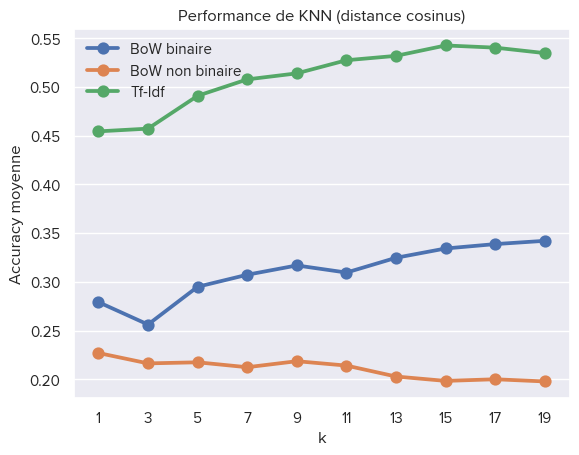

In [20]:
k_values, means = np.arange(1, 21, 2), []

for k in k_values:
    print(k)
    np.random.seed(1)
    classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=k, C=n_classes, dist_type="cosine")

    (_, mean_bow_bin, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_bin, news_labels), 5, False, False)
    (_, mean_bow_freq, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_freq, news_labels), 5, False, False)
    (_, mean_tfidf, _) = ev.validation_croisee(classifier_knn, (news_desc_tfidf, news_labels), 5, False, False)

    means.append([mean_bow_bin, mean_bow_freq, mean_tfidf])

data=pd.DataFrame(data={"k":k_values, "mean accuracy":means})
data[['BoW binaire', 'BoW non binaire', "Tf-Idf"]] = pd.DataFrame(data["mean accuracy"].to_list(),
                                                                  columns=['BoW binaire', 'BoW non binaire', "Tf-Idf"],
                                                                  index = data.index)
data = data.drop(columns="mean accuracy")
data = data.melt(id_vars="k", value_vars=['BoW binaire', 'BoW non binaire', "Tf-Idf"], var_name="vectorisation", value_name="Accuracy moyenne")

ax = sns.pointplot(data, x="k", y="Accuracy moyenne", hue="vectorisation")
ax.legend(frameon=False, loc="upper left")
ax.set_title("Performance de KNN (distance cosinus)")
plt.savefig("images/sw/knn_cosine.svg", dpi=150, bbox_inches="tight", format="svg")

#### **Bag-of-words binaire**

In [12]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

# BoW binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True)
news_desc.shape

(1819, 3411)

##### KNN multi-classe [distance **euclidienne**] k = 1

Results [0.08146067415730338, 0.10955056179775281, 0.10674157303370786, 0.10674157303370786, 0.09269662921348315]
Mean accuracy 0.0994, std : 0.0107
Time 1.7630741596221924


Text(0.5, 1.0, 'Confusion matrix')

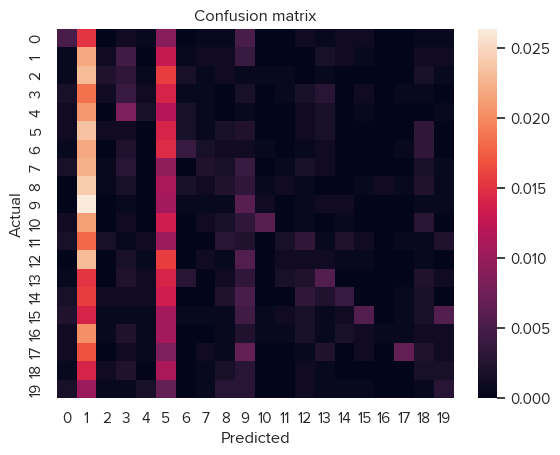

In [13]:

np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=1, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**] k = 13

Results [0.351123595505618, 0.32303370786516855, 0.3455056179775281, 0.2949438202247191, 0.3089887640449438]
Mean accuracy 0.3247, std : 0.0213
Time 2.282089948654175


Text(0.5, 1.0, 'Confusion matrix')

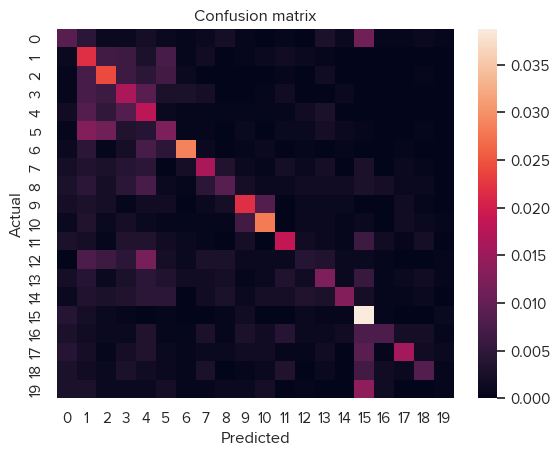

In [14]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=13, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

------ affichage validation croisée
Itération 0: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4607
Itération 1: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4522
Itération 2: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4803
Itération 3: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4579
Itération 4: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4466
------ fin affichage validation croisée
Results [0.4606741573033708, 0.45224719101123595, 0.4803370786516854, 0.45786516853932585, 0.44662921348314605]
Mean accuracy 0.4596, std : 0.0115
Time 163.91360306739807


Text(0.5, 1.0, 'Confusion matrix')

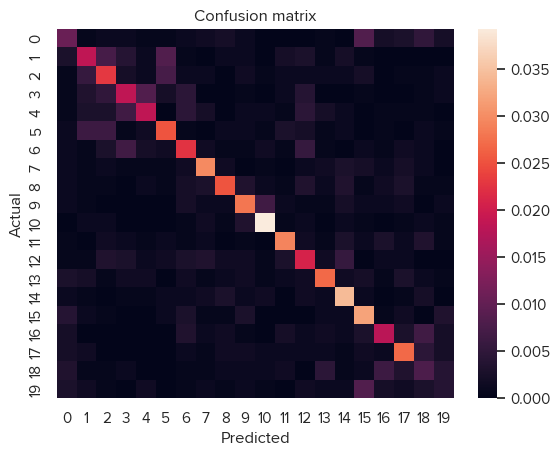

In [11]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre de décision

------ affichage validation croisée
	*** Warning: attribut  att_7  -> Valeur inconnue:  154
	*** Warning: attribut  att_13  -> Valeur inconnue:  1
	*** Warning: attribut  att_13  -> Valeur inconnue:  7
	*** Warning: attribut  att_79  -> Valeur inconnue:  4
	*** Warning: attribut  att_99  -> Valeur inconnue:  7
	*** Warning: attribut  att_13  -> Valeur inconnue:  4
	*** Warning: attribut  att_99  -> Valeur inconnue:  7
	*** Warning: attribut  att_1545  -> Valeur inconnue:  3
	*** Warning: attribut  att_13  -> Valeur inconnue:  4
	*** Warning: attribut  att_13  -> Valeur inconnue:  0
	*** Warning: attribut  att_13  -> Valeur inconnue:  3
	*** Warning: attribut  att_13  -> Valeur inconnue:  2
	*** Warning: attribut  att_122  -> Valeur inconnue:  2
	*** Warning: attribut  att_13  -> Valeur inconnue:  0
	*** Warning: attribut  att_1570  -> Valeur inconnue:  2
	*** Warning: attribut  att_13  -> Valeur inconnue:  4
	*** Warning: attribut  att_13  -> Valeur inconnue:  2
	*** Warning: attribut 

Text(0.5, 1.0, 'Confusion matrix')

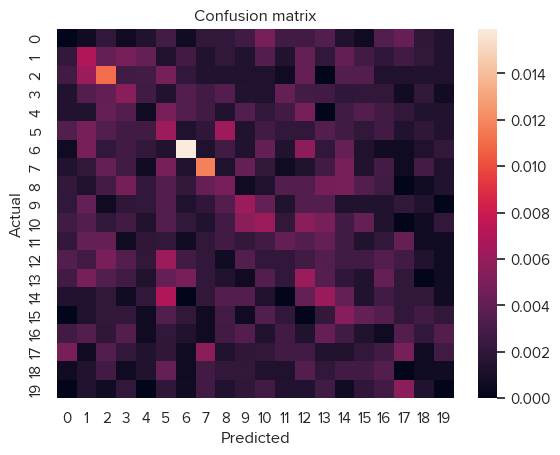

In [12]:
np.random.seed(1)
tree_decision = classif.ClassifierArbreDecision(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_decision, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

#### **Bag-of-words avec fréquence**

In [13]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

# BoW non binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)
news_desc.shape

(1819, 3411)

##### KNN multi-classe [distance **euclidienne**] k = 1

Results [0.12078651685393259, 0.12078651685393259, 0.14606741573033707, 0.13764044943820225, 0.1151685393258427]
Mean accuracy 0.1281, std : 0.0117
Time 1.7260041236877441


Text(0.5, 1.0, 'Confusion matrix')

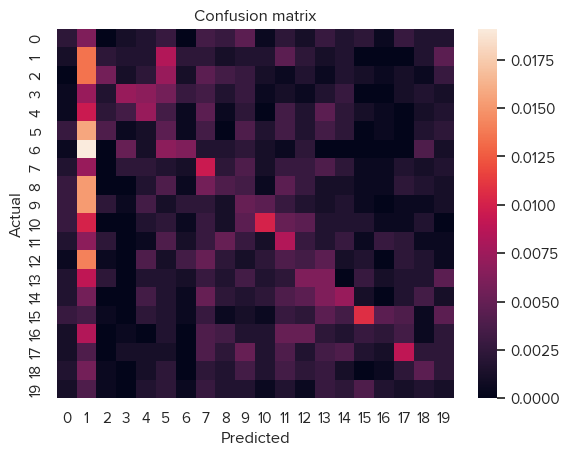

In [14]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=1, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**] k = 13

Results [0.2247191011235955, 0.18820224719101122, 0.21629213483146068, 0.19662921348314608, 0.18820224719101122]
Mean accuracy 0.2028, std : 0.0150
Time 2.247070074081421


Text(0.5, 1.0, 'Confusion matrix')

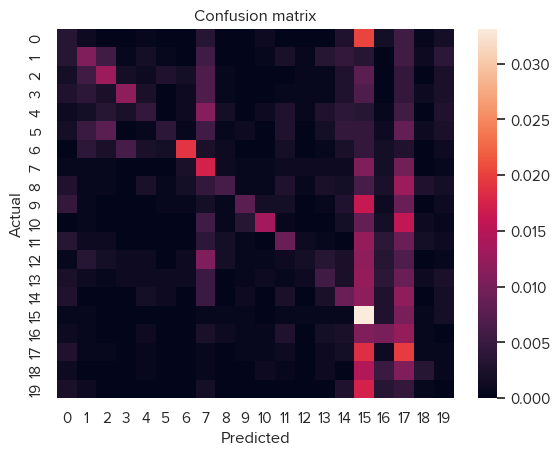

In [15]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=13, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

------ affichage validation croisée
Itération 0: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4607
Itération 1: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4522
Itération 2: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4803
Itération 3: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4579
Itération 4: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.4466
------ fin affichage validation croisée
Results [0.4606741573033708, 0.45224719101123595, 0.4803370786516854, 0.45786516853932585, 0.44662921348314605]
Mean accuracy 0.4596, std : 0.0115
Time 163.29854798316956


Text(0.5, 1.0, 'Confusion matrix')

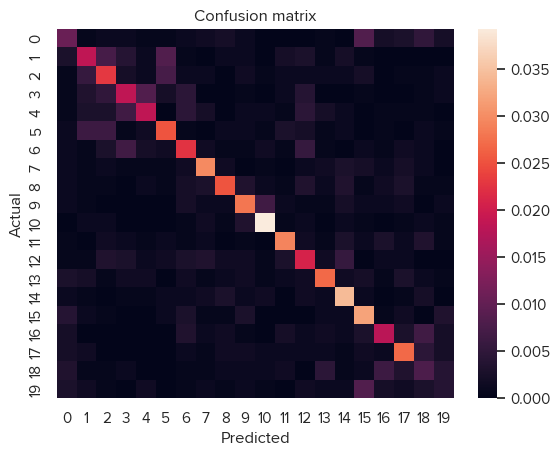

In [16]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre numérique

------ affichage validation croisée
Itération 0: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.2556
Itération 1: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.2163
Itération 2: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.2669
Itération 3: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.2303
Itération 4: taille de base app.=1463	taille base test=356	Taux de bonne classif: 0.2612
------ fin affichage validation croisée
Results [0.2556179775280899, 0.21629213483146068, 0.26685393258426965, 0.2303370786516854, 0.2612359550561798]
Mean accuracy 0.2461, std : 0.0194
Time 846.6175029277802


Text(0.5, 1.0, 'Confusion matrix')

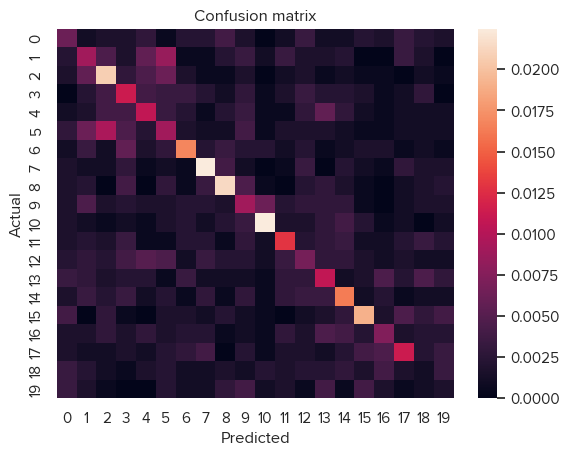

In [17]:
np.random.seed(1)
tree_numerical = classif.ClassifierArbreNumerique(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_numerical, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

### **Vectorisation avec TF-IDF**

In [18]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

news_desc = get_tfidf_vect(news_no_stopwords, corpus)
news_desc.shape

(1819, 3411)

##### KNN multi-classe [distance **euclidienne**] k = 1

Results [0.21629213483146068, 0.17415730337078653, 0.24157303370786518, 0.20786516853932585, 0.1797752808988764]
Mean accuracy 0.2039, std : 0.0247
Time 1.266921043395996


Text(0.5, 1.0, 'Confusion matrix')

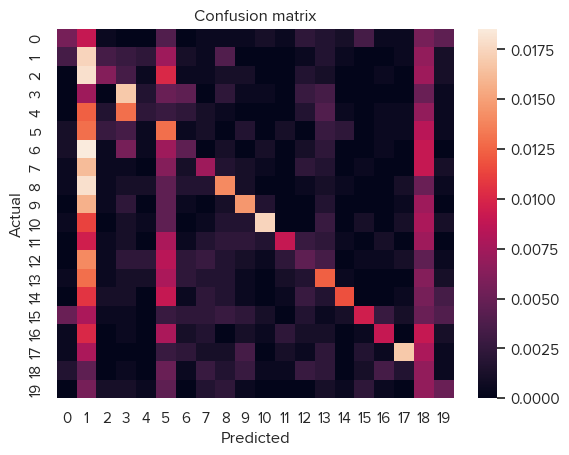

In [19]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=1, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**] k = 13

Results [0.550561797752809, 0.5252808988764045, 0.5140449438202247, 0.5252808988764045, 0.5449438202247191]
Mean accuracy 0.5320, std : 0.0136
Time 1.9708127975463867


Text(0.5, 1.0, 'Confusion matrix')

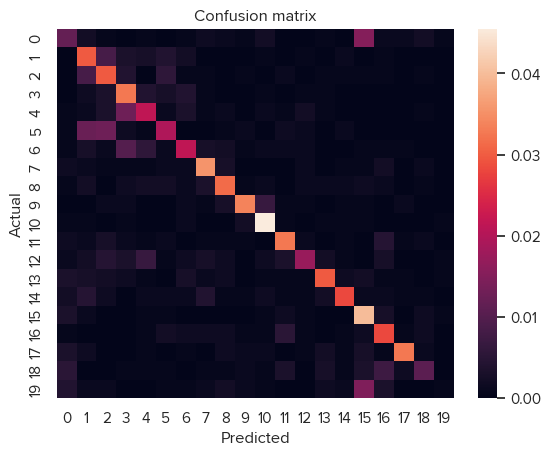

In [20]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=13, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

Results [0.46348314606741575, 0.45786516853932585, 0.48314606741573035, 0.4606741573033708, 0.4943820224719101]
Mean accuracy 0.4719, std : 0.0143
Time 121.11395001411438


Text(0.5, 1.0, 'Confusion matrix')

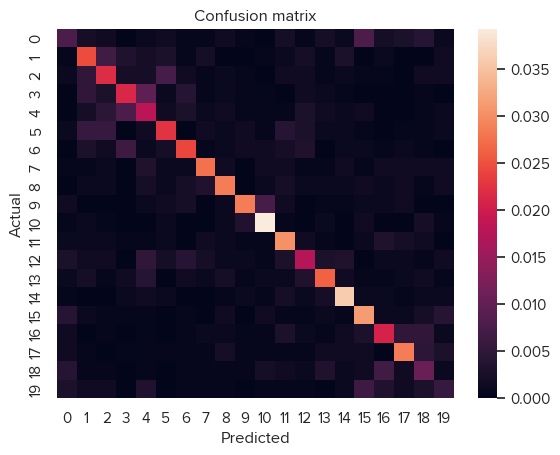

In [21]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre numérique
Trop long (1 itération 80% train, 20% test ~20 min)

In [167]:
np.random.seed(1)
tree_numerical = classif.ClassifierArbreNumerique(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_numerical, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

------ affichage validation croisée
Itération 0: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2758


KeyboardInterrupt: 